#Autocrop

This notebook can automatically crop around images of fish in order to remove the background. The goal is to remove uncessary information in order to improve model performance and reduce memory use.

#Mount Google Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Requirements

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel
from skimage.color import rgb2gray
from tqdm import trange

#Configurations

In [21]:
ORIGINAL_IMAGES = '/content/drive/MyDrive/MFAC-Deliverables/X_b.npy'
CROPPED_IMAGES = '/content/drive/MyDrive/MFAC-Deliverables/X_cropped_b.npy'

#Crop Images

In [22]:
def moving_average(arr, n=3):
    padded_arr = np.concatenate((np.flip(arr[:n]), arr, np.flip(arr[-n:])))
    return np.convolve(padded_arr, np.ones(2 * n + 1) / (2 * n + 1), mode='valid')


def auto_crop(image, target_width=750, target_height=130, xbuffer=15, ybuffer=10):
    if target_width <= 0:
        raise ValueError(f'target_width {target_width} must be greater than zero')
    if target_height <= 0:
        raise ValueError(f'target_height {target_height} must be greater than zero')
    if xbuffer <= 0:
        raise ValueError(f'xbuffer {xbuffer} must be greater than zero')
    if ybuffer <= 0:
        raise ValueError(f'ybuffer {ybuffer} must be greater than zero')
    if image.shape[0] < target_height or image.shape[1] < target_width :
        raise ValueError(f'Image height and width [{image.shape[0]}, {image.shape[1]}] is smaller than the target height and width [{target_height}, {target_width}]')

    edges = sobel(rgb2gray(image))
    columns = np.sum(edges, axis=0)
    smoothed_columns = np.array(moving_average(columns, 2 * xbuffer + 1))

    left = 0
    right = len(smoothed_columns) - 1
    while right - left + 1 > target_width:
        if smoothed_columns[left] < smoothed_columns[right]:
            left += 1
        else:
            right -= 1
    image = image[:, left:right + 1, :]
    edges = edges[:, left:right + 1]
    # plt.plot(columns)
    # plt.plot(smoothed_columns)
    # plt.axvline(left, color='r')
    # plt.axvline(right, color='r')
    # plt.show()

    rows = np.sum(edges, axis=1)
    smoothed_rows = np.array(moving_average(rows, 2 * ybuffer + 1))
    top = 0
    bottom = len(smoothed_rows) - 1
    while bottom - top + 1 > target_height:
        if smoothed_rows[top] < smoothed_rows[bottom]:
            top += 1
        else:
            bottom -= 1
    # plt.plot(rows)
    # plt.plot(smoothed_rows)
    # plt.axvline(top, color='r')
    # plt.axvline(bottom, color='r')
    # plt.show()
    image = image[top:bottom + 1, :, :]
    return image

In [ ]:
images = np.load(ORIGINAL_IMAGES)
print(f'Input images shape: {images.shape}')

print('Cropping images...')
cropped_images = [[-1] * images.shape[1]] * images.shape[0]
for i in trange(images.shape[0], unit='sets'):
    for j in range(images.shape[1]):
        cropped_images[i][j] = auto_crop(images[i][j])
    cropped_images[i] = np.stack(cropped_images[i])
print('Formatting array...')
cropped_images = np.stack(cropped_images)
print(f'Cropped images shape: {cropped_images.shape}')
print('Saving array...')
np.save(CROPPED_IMAGES, cropped_images)
print('Done')

#Inspect Crop

Building plot...
Index: 5


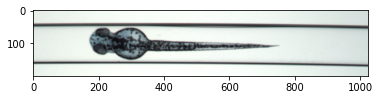

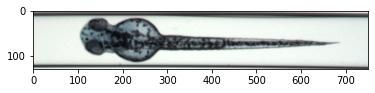

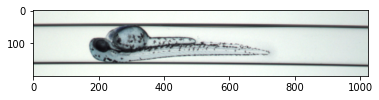

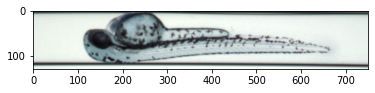

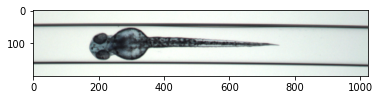

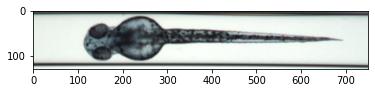

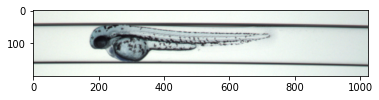

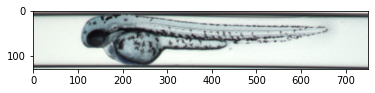

Index: 20


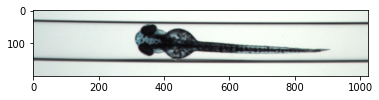

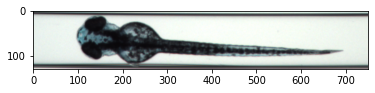

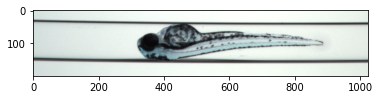

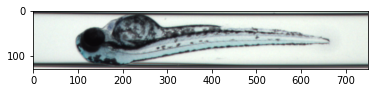

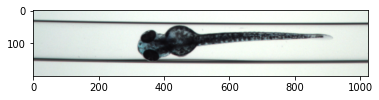

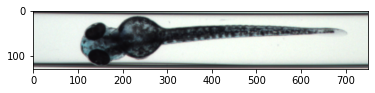

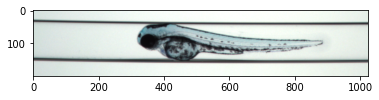

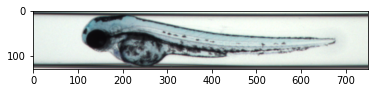

Index: 40


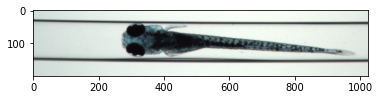

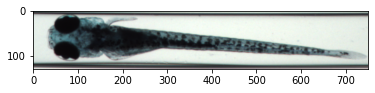

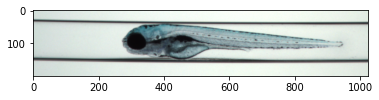

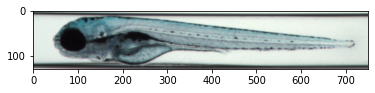

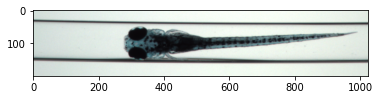

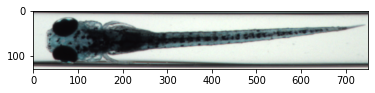

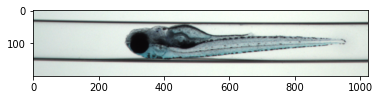

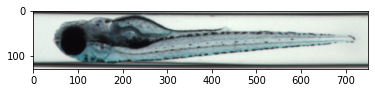

In [24]:
# number of sets of images to inspect
n = 3
print('Building plot...')
batch_size = images.shape[1]
indices = np.sort(np.random.choice(range(images.shape[0]), size=n, replace=False))
for index in indices:
  print(f'Index: {index}')
  for j in range(batch_size):
    plt.imshow(images[index][j])
    plt.show()
    plt.imshow(cropped_images[index][j])
    plt.show()